Jinal Vyas
1233053785
Part - 1 Data Preparation Report

In [ ]:
# Here, I am using the data of bands 3 to 7 from Landsat-8 of NASA over the Alaska Mendanhall Glacier, derived through Google Earth Engine

# The product I am using is Landsat 8 OLI/TIRS Collection 2 atmospherically corrected surface reflectance, Tier-1, because without atmospheric correction,
# the raw reflectance values can be influenced by the time of day, weather conditions, and the atmospheric content, making it difficult to analyze the Earth's surface accurately across different times or locations.

# For the EDA representation purpose, I am taking the data of two months from 1st October 2023 to 1st Decemeber 2023
# Landsat collects images every 16 days, but here I have derived the images after applying cloud mask, hence clearing cloudy images.
# I have performed EDA on the tif file I derived from the median of pixels from two months of the above data product.
# In the next stage I will replicate this processing on data files of more years and perform segmentation of glaciers.

In [1]:
# Rasterio is a Python library used for reading, writing, and processing raster data, typically in GeoTIFF format.
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.1 MB/s eta 0:00:00


In [147]:
# geemap is the Python API of Google Earth Engine
import ee
import geemap.core as geemap
import torch
import rasterio
from torch.utils.data import Dataset, dataloader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import seaborn as sns

In [4]:
ee.Authenticate()
ee.Initialize(project='ee-jinalvyasict19')

In [201]:
# viewing data over entire global map keeping North America as center
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2023-10-01', '2023-12-01'
)

def apply_scale_factors(image):
  optical_bands = image.select(['SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']).multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

m = geemap.Map()
m.set_center(-104.88, 50.35, 3)
m.add_layer(dataset, visualization, 'True Color (432)')
m

Map(center=[50.35, -104.88], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [116]:
# code to apply cloud masking for clear view
def mask_clouds_shadows(image):
  qa_mask = image.select('QA_PIXEL')
  cloud_mask = (qa_mask.bitwiseAnd(1 << 3)).eq(0)
  shadow_mask = (qa_mask.bitwiseAnd(1 << 4)).eq(0)
  mask = cloud_mask.And(shadow_mask)
  return image.updateMask(mask)

dataset = dataset.map(mask_clouds_shadows)

In [198]:
# # viewing data over entire global map keeping Alaska Mendanhall Glacier as center
m = geemap.Map()
m.set_center(-134.62, 58.42, 6)
m.add_layer(dataset, visualization, 'True Color (432)')
m

Map(center=[58.42, -134.62], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [200]:
# defining Mendanhall Glacier as region of interest
alaska_bounds = ee.Geometry.Polygon([[-134.62, 58.42], [-134.62, 58.59], [-134.42, 58.59], [-134.42, 58.42]])
map = geemap.Map()
map.centerObject(alaska_bounds, 10)
map.addLayer(alaska_bounds, {'color': 'lightblue'}, 'Alaska Mendanhall Glacier')
map

Map(center=[58.504970268291245, -134.5199999999993], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [120]:
# If your dataset is made up of multiple images, you’re creating a composite where the pixel value is the median of the corresponding pixel values
# from all the images at that location.
image = dataset.median().clip(alaska_bounds)

In [124]:
# downloading the image, am using high resolution of 10, which will increase data size a bit.
export_task = ee.batch.Export.image.toDrive(
    image = image,
    description = 'alaska_image',
    scale = 10,
    region = alaska_bounds,
    maxPixels = 1e13,
    fileFormat = 'GeoTIFF',
    folder = 'EarthEngineExports_Alaska'
)

export_task.start()

In [125]:
# I will be using SR_B3 to SR_B7 for now, as they are enough for snow segmentation, other bands represent different atmospheric properties
# like a fusion of panchromatic and lower-resolution bands for better spatial resolution
image

In [126]:
# downloading the dataset into google drive clipped to Mendanhall Glacier's bounds
import time
while export_task.active():
  print('Polling for task (id: {}).'.format(export_task.id))
  time.sleep(5)

Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id: MQNN3XYHIUL3XKB4NSE5FM37).
Polling for task (id

# Exploratory Data Analysis

In [128]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [129]:
# Loading the tiff file derived from median of pixels over multiple images of two months
dataset = gdal.Open('/content/drive/My Drive/EarthEngineExports_Alaska/alaska_image.tif')

print(dataset.GetMetadata())
print("Number of Bands:", dataset.RasterCount)
print("GeoTransform:", dataset.GetGeoTransform())

{'AREA_OR_POINT': 'Area'}
Number of Bands: 19
GeoTransform: (-134.62000134216848, 8.983152841195215e-05, 0.0, 58.59000929237184, 0.0, -8.983152841195215e-05)


In [130]:
# making sure that the data is not entirely empty, hence loaded properly.
dataset.GetRasterBand(1).ReadAsArray()

array([[33328., 33328., 33328., ..., 44065., 44065., 43669.],
       [33328., 33328., 33328., ..., 44547., 44547., 44164.],
       [36721., 36721., 36721., ..., 44547., 44547., 44164.],
       ...,
       [ 7658.,  7658.,  7658., ..., 16850., 16850., 16850.],
       [ 7568.,  7568.,  7568., ..., 23831., 23831., 23831.],
       [ 7568.,  7568.,  7568., ..., 23831., 23831., 23831.]])

In [132]:
np.nanmax(dataset.GetRasterBand(1).ReadAsArray())

65454.0

In [135]:
# Printing the Meta-Data In Detail
with rasterio.open('/content/drive/My Drive/EarthEngineExports_Alaska/alaska_image.tif') as src:
    print(f"Number of Bands: {src.count}")
    for band in range(1, src.count + 1):
        print(f"Band {band}: {src.descriptions[band - 1]}")

Number of Bands: 19
Band 1: SR_B1
Band 2: SR_B2
Band 3: SR_B3
Band 4: SR_B4
Band 5: SR_B5
Band 6: SR_B6
Band 7: SR_B7
Band 8: SR_QA_AEROSOL
Band 9: ST_B10
Band 10: ST_ATRAN
Band 11: ST_CDIST
Band 12: ST_DRAD
Band 13: ST_EMIS
Band 14: ST_EMSD
Band 15: ST_QA
Band 16: ST_TRAD
Band 17: ST_URAD
Band 18: QA_PIXEL
Band 19: QA_RADSAT


# Data Cleaning and EDA Continued

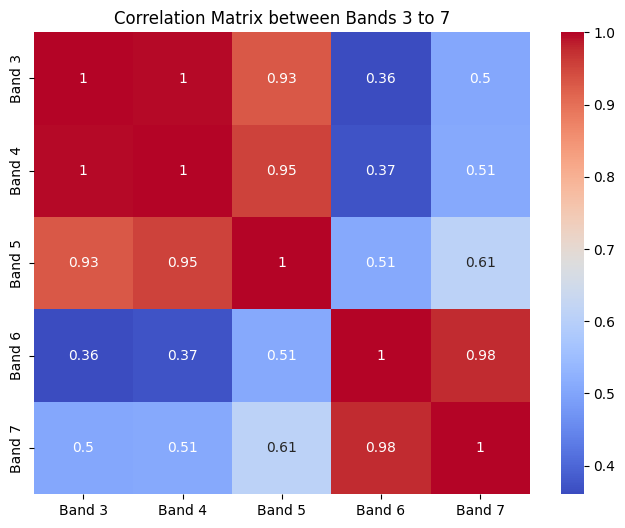

In [184]:
# Here, there are several Nan values because of these reasons:
# Satellite imagery can have NaN values in regions affected by clouds, cloud shadows, or other atmospheric disturbances where reflectance values
# cannot be accurately measured.
# Some pixels may represent areas where no data is available (e.g., out of the image bounds, in remote regions, or where the sensor failed to collect data).
# Hence, it is in best interest to replace these NaN values by just zero for simplicity of computation and not some other values because replacing NaN
# values with arbitrary values (e.g., zero or the mean of surrounding pixels) introduces bias. It distorts the actual reflectance data and can affect
# any further analysis, such as classification, index calculation (like NDSI or NDVI), or any machine learning model.

# Plotting heatmap correlation matrix, to see relation between multiple bands, some pairs like 6-7, 3-5, 4-5 seem to be highly correlated.

with rasterio.open(file_path) as src:
    band_3 = src.read(3)
    band_4 = src.read(4)
    band_5 = src.read(5)
    band_6 = src.read(6)
    band_7 = src.read(7)

band_3 = np.nan_to_num(band_3, nan=0)
band_4 = np.nan_to_num(band_4, nan=0)
band_5 = np.nan_to_num(band_5, nan=0)
band_6 = np.nan_to_num(band_6, nan=0)
band_7 = np.nan_to_num(band_7, nan=0)

band_3_flat = band_3.flatten()
band_4_flat = band_4.flatten()
band_5_flat = band_5.flatten()
band_6_flat = band_6.flatten()
band_7_flat = band_7.flatten()


data = np.stack([band_3_flat, band_4_flat, band_5_flat, band_6_flat, band_7_flat])

correlation_matrix = np.corrcoef(data)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7"],
            yticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7"])
plt.title('Correlation Matrix between Bands 3 to 7')
plt.show()

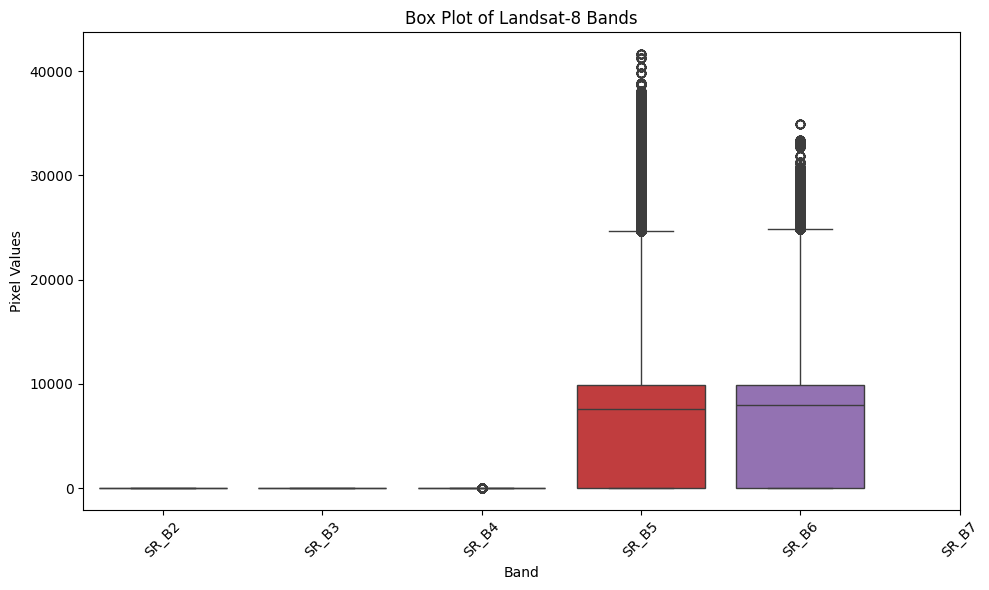

In [173]:
# Here, though there are outliers, but they may represent extreme temperature components like snow, so I am not removing the outliers.
all_bands = [band_3_flat, band_4_flat, band_5_flat, band_6_flat, band_7_flat]
band_names = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

plt.figure(figsize=(10, 6))
sns.boxplot(data=all_bands)
plt.xticks(np.arange(len(band_names)), band_names, rotation=45)
plt.title("Box Plot of Landsat-8 Bands")
plt.xlabel("Band")
plt.ylabel("Pixel Values")
plt.tight_layout()
plt.show()

# Feature Engineering

<ipython-input-185-277dda5d0dc9>:3: RuntimeWarning: invalid value encountered in divide
  NDSI = (band_3 - band_6) / (band_3 + band_6)


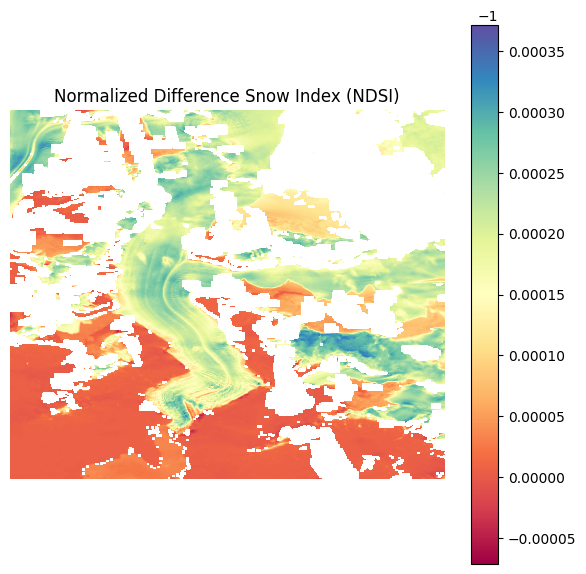

In [185]:
# Performing Feature Engineering, i.e. deriving a new feature named NDSI (Normalized Difference Snow Index) from Bands 3 and 6.
# NDSI is typically used to detect snow and ice, as these features often have a high reflectance in the Green band and
# a lower reflectance in the SWIR bands, which yields positive NDSI values

NDSI = (band_3 - band_6) / (band_3 + band_6)

# Plot NDSI
plt.figure(figsize=(7, 7))
plt.imshow(NDSI, cmap='Spectral')
plt.title('Normalized Difference Snow Index (NDSI)')
plt.colorbar()
plt.axis('off')
plt.show()

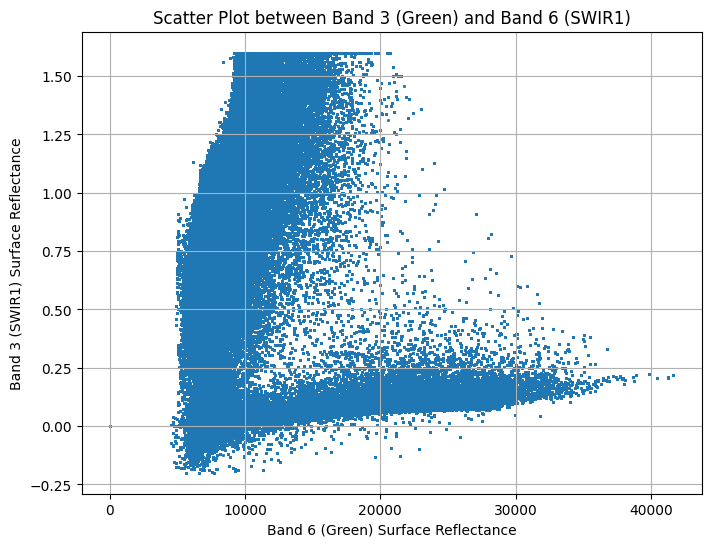

In [176]:
# visualizing correlation between 3 and 6 to understand NDSI further
# For Snow/Ice: The Green band (Band 3) will have higher values (as snow reflects visible light), and the SWIR1 band (Band 6) will have lower values
#  (since snow absorbs infrared light). This results in a positive NDSI values.
plt.figure(figsize=(8, 6))
plt.scatter(band_6_flat, band_3_flat, alpha=0.5, s=1)  # s=1 for small points, alpha for transparency
plt.title("Scatter Plot between Band 3 (Green) and Band 6 (SWIR1)")
plt.xlabel("Band 6 (Green) Surface Reflectance")
plt.ylabel("Band 3 (SWIR1) Surface Reflectance")
plt.grid(True)
plt.show()

# EDA Continued

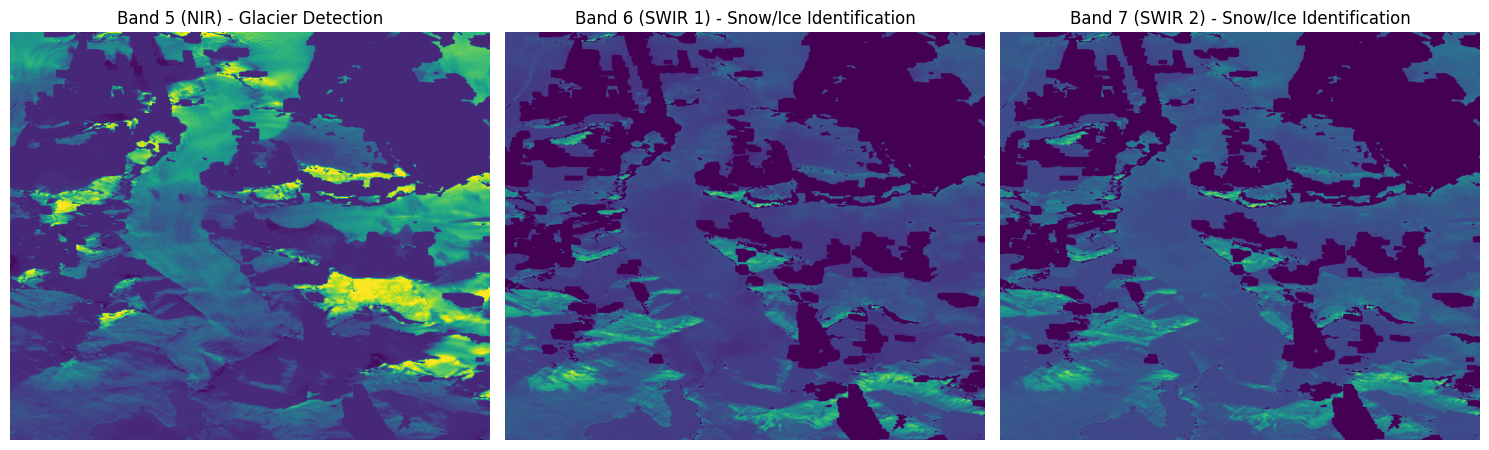

In [196]:
# Plotting band 5, 6 and 7.
# NIR (Band-5)  is useful for vegetation monitoring, SWIR1 (Band-6) is sensitive to moisture content, and wet surfaces such as soil, vegetation, or
# water tend to reflect differently in this band. SWIR2 (Band-7) is important for detecting moisture in soil and vegetation, as well as for
# distinguishing water from other land covers.
file_path = "/content/drive/My Drive/EarthEngineExports_Alaska/alaska_image.tif"

with rasterio.open(file_path) as src:
    band_5 = src.read(5)  # NIR (Near Infrared)
    band_6 = src.read(6)  # SWIR 1
    band_7 = src.read(7)  # SWIR 2

band_5 = np.nan_to_num(band_5, nan=0)
band_6 = np.nan_to_num(band_6, nan=0)
band_7 = np.nan_to_num(band_7, nan=0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(band_5)
axes[0].set_title('Band 5 (NIR) - Glacier Detection')
axes[0].axis('off')

axes[1].imshow(band_6)
axes[1].set_title('Band 6 (SWIR 1) - Snow/Ice Identification')
axes[1].axis('off')


axes[2].imshow(band_7)
axes[2].set_title('Band 7 (SWIR 2) - Snow/Ice Identification')
axes[2].axis('off')

plt.tight_layout()
plt.show()

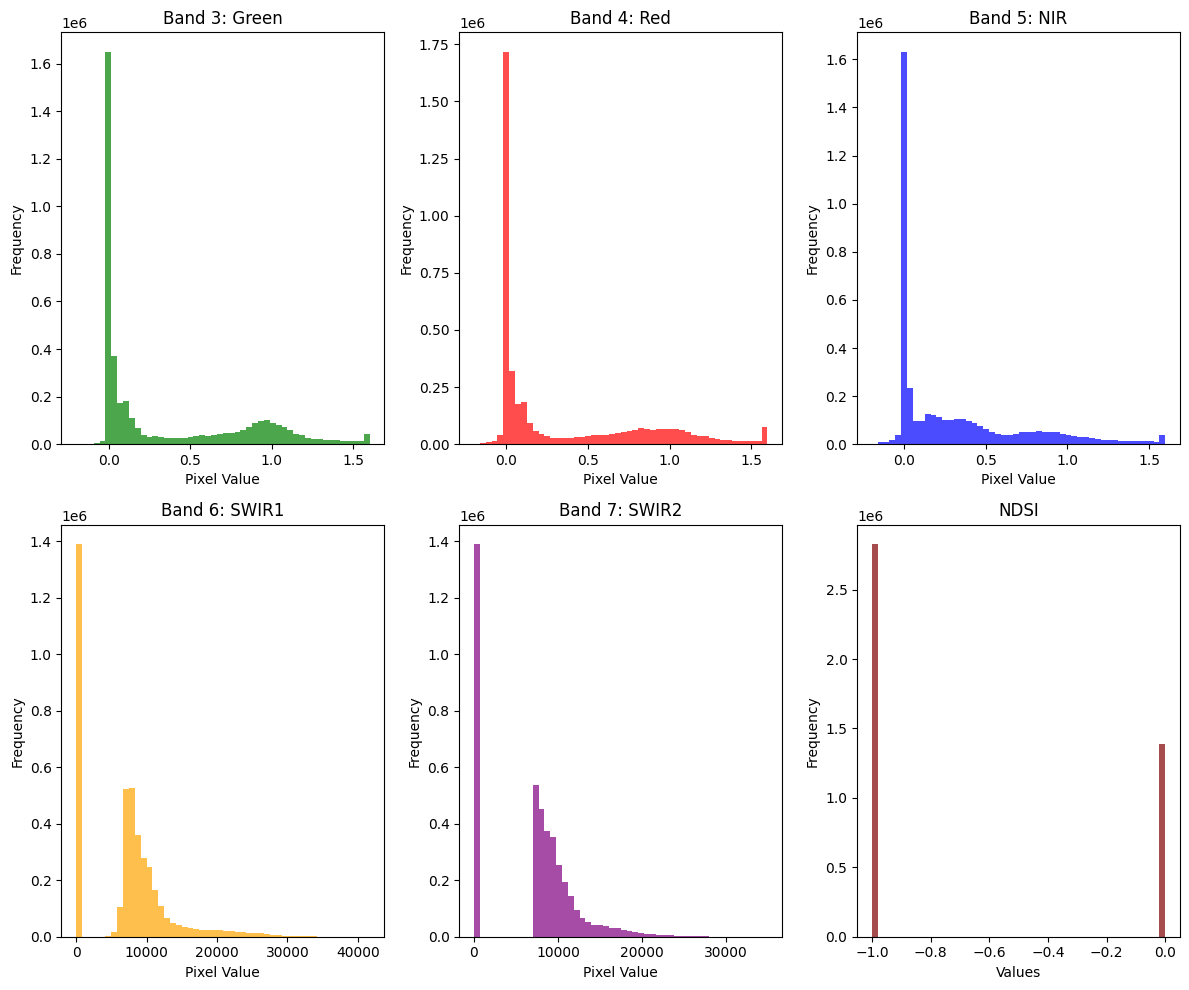

In [169]:
# Plotting the histogram to understand the data distribution, and what natural phenomenon is represented by different values of variables such as NDSI.

# Summary of ALL BANDS and NDSI:
# Band 3 (Green) represents the visible green light reflected by vegetation, useful for vegetation studies.
# Band 4 (Red) corresponds to the visible red light and is sensitive to chlorophyll absorption, helping in vegetation health monitoring.
# Band 5 (NIR) captures near-infrared light, with high reflectance from healthy vegetation, making it crucial for vegetation analysis.
# Band 6 (SWIR1) detects moisture content in soil, vegetation, and water, with lower reflectance from snow and ice.
# Band 7 (SWIR2) also measures moisture, with snow and ice showing low reflectance, and is used for distinguishing wet surfaces.
# The NDSI (Normalized Difference Snow Index) uses Band 3 and Band 6 to highlight snow and ice by comparing their different reflectance properties
# in the visible and SWIR bands; values close to 0 indicate non-snow surfaces, while higher values (>0.4) represent snow.

# here, normalizing any of the band values, can deteriorate the characteristics separation of glacier phenomenon, hence I am not normalizing them.

plt.figure(figsize=(12, 10))

# Band 3: Green
plt.subplot(2, 3, 1)
plt.hist(band_3_flat, bins=50, color='green', alpha=0.7)
plt.title('Band 3: Green')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Band 4: Red
plt.subplot(2, 3, 2)
plt.hist(band_4_flat, bins=50, color='red', alpha=0.7)
plt.title('Band 4: Red')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Band 5: NIR
plt.subplot(2, 3, 3)
plt.hist(band_5_flat, bins=50, color='blue', alpha=0.7)
plt.title('Band 5: NIR')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Band 6: SWIR1
plt.subplot(2, 3, 4)
plt.hist(band_6_flat, bins=50, color='orange', alpha=0.7)
plt.title('Band 6: SWIR1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Band 7: SWIR2
plt.subplot(2, 3, 5)
plt.hist(band_7_flat, bins=50, color='purple', alpha=0.7)
plt.title('Band 7: SWIR2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
plt.hist(NDSI_flat, bins=50, color='maroon', alpha=0.7)
plt.title('NDSI')
plt.xlabel('Values')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

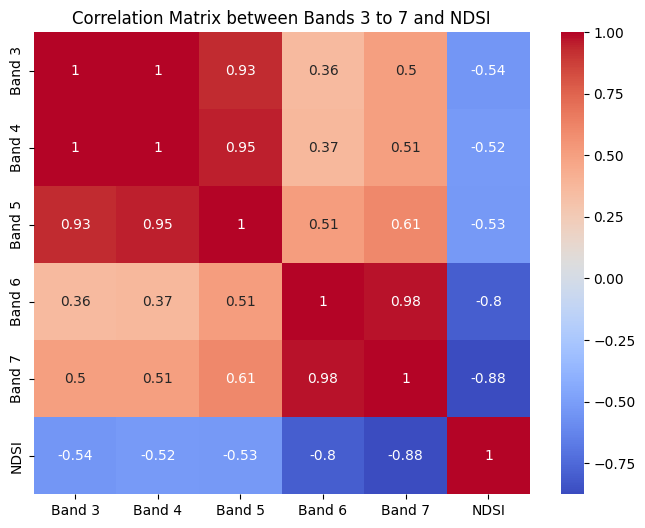

In [186]:
# Replotting the correlation matrix with NDSI included, and it is obvious that it will be highly correlated to band 3 and 6.
# But the high correlation between band 7 and NDSI can be due to the fact that there are similar spectral characteristics of snow and ice in both the
# SWIR (Shortwave Infrared) bands, particularly Band 6 (SWIR1) and Band 7 (SWIR2).
NDSI = np.nan_to_num(NDSI, nan=0)
NDSI_flat = NDSI.flatten()
data = np.stack([band_3_flat, band_4_flat, band_5_flat, band_6_flat, band_7_flat, NDSI_flat])

correlation_matrix = np.corrcoef(data)

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7", "NDSI"],
            yticklabels=["Band 3", "Band 4", "Band 5", "Band 6", "Band 7", "NDSI"])
plt.title('Correlation Matrix between Bands 3 to 7 and NDSI')
plt.show()

In [187]:
# Min value of NDSI being -1.0:
# This suggests that in some areas, the difference between the Green band (Band 3) and the SWIR band (Band 6) is negative, and
# the reflectance in the SWIR band is much higher than in the Green band. The minimum value of -1.0 implies that the Green band is
# extremely small or close to zero compared to the SWIR band in these areas.
# Max value of 0.0:
# The maximum value of 0.0 suggests that in all of the image, there are no areas where the Green reflectance exceeds the SWIR reflectance to the
# point that the result is positive.
# Mean of -0.67:
# A mean value of -0.67 indicates that, on average, the Green reflectance is significantly lower than the SWIR reflectance.
# This is usually expected for non-snow/ice-covered areas (e.g., forests, urban areas), where the SWIR reflectance is generally higher than
# the Green reflectanc

NDSI = np.nan_to_num(NDSI, nan=0)
print("NDSI min:", NDSI.min(), "max:", NDSI.max(), "mean:", NDSI.mean())

NDSI min: -1.0000713605834395 max: 0.0 mean: -0.6704336916204889


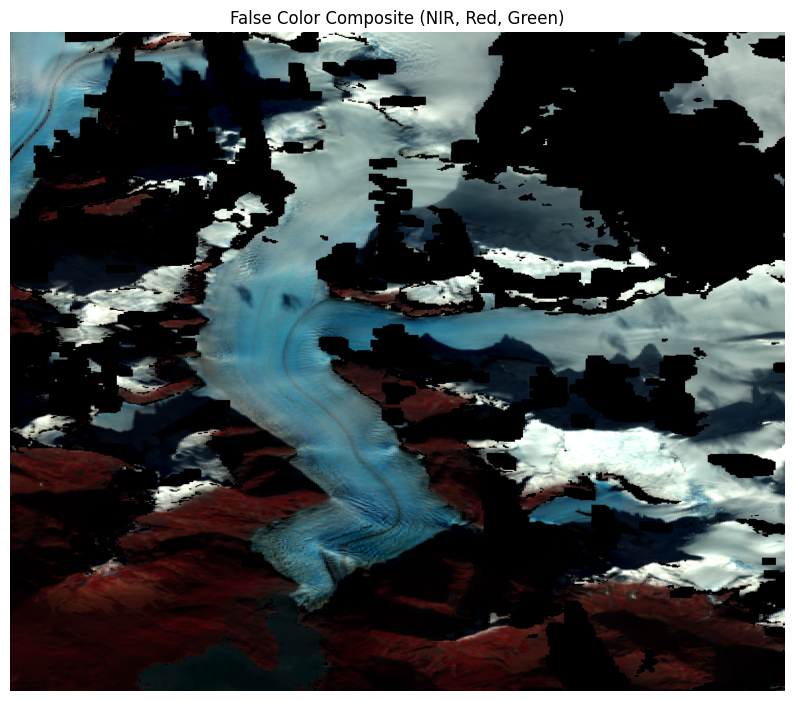

In [188]:
# Using the three bands to plot an RGB image of glacier characteristics measured over 2 months
band_5_norm = band_5 / band_5.max()
band_4_norm = band_4 / band_4.max()
band_3_norm = band_3 / band_3.max()

rgb_image = np.stack((band_5_norm, band_4_norm, band_3_norm), axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("False Color Composite (NIR, Red, Green)")
plt.axis('off')
plt.show()


In [ ]:
# Further Steps: I will either use the NDSI image or the RGB Image to perform segmentation (Model probably will be UNet, UNet+ or UperNet
# (may be with Swin Backbone)), and then I will perform classification, on initial stage I will keep it simple i.e. binary classificatin
# (whether snow is present or absent), which if time permits will further include classes like water and vegetation.